### Results for first trial with deepethogram

Initially trained on one session of 70 trials with jaaba output labels

Predicted for one session same animal, and one session different animal (both 80 trials)

In [1]:
from animal_soup import *
import pandas as pd
import numpy as np
import os
from pathlib import Path
from cv2 import EMD, DIST_L2
from tqdm import tqdm

2023-05-31 09:16:45.054940: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 09:16:45.501622: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/clewis7/repos/animal-soup/animal_soup/batch_utils.py:137: UserWarning: registration of accessor <class 'animal_soup.batch_utils.PathsDataFrameExtension'> under name 'paths' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("paths")
/home/clewis7/repos/animal-soup/animal_soup/batch_utils.py:142: UserWarning: registration of accessor <class 'animal_soup.batch_utils.PathsSeriesExtension'> under name 'paths' for type <class 'pandas.core.series.Series'> i

In [2]:
training_data_path = set_parent_raw_data_path('/data/caitlin/training-vids/')
df_path = get_parent_raw_data_path().joinpath('data-frames/deepetho_results.hdf')

In [3]:
df = load_df(df_path)

In [4]:
df

,animal_id,session_id,mat_path,deg_path,session_vids,notes
0,M235Slc17a7_Gtacr2,20170424,M235Slc17a7_Gtacr2/20170424/jaaba.mat,M235Slc17a7_Gtacr2/20170424/deg_labels.npy,[M235Slc17a7_Gtacr2/20170424/M235_20170424_v00...,None
1,M235Slc17a7_Gtacr2,20170425,M235Slc17a7_Gtacr2/20170425/jaaba.mat,None,[M235Slc17a7_Gtacr2/20170425/M235_20170425_v00...,None
2,M236Slc17a7_Gtacr2,20170501,M236Slc17a7_Gtacr2/20170501/jaaba.mat,M236Slc17a7_Gtacr2/20170501/deg_labels.npy,[M236Slc17a7_Gtacr2/20170501/M236_20170501_v00...,None


In [5]:
container = df.behavior.comparison_view()

/home/clewis7/venvs/mescore/lib/python3.11/site-packages/ipydatagrid/datagrid.py:445: UserWarning: Index name of 'index' is not round-trippable.
  schema = pd.io.json.build_table_schema(dataframe)


RFBOutputContext()

/home/clewis7/repos/mesmerize-core/mesmerize_core/arrays/_video.py:87: UserWarning: min not implemented for LazyTiff, returning min of 0th index
  warn("min not implemented for LazyTiff, returning min of 0th index")
/home/clewis7/repos/mesmerize-core/mesmerize_core/arrays/_video.py:92: UserWarning: max not implemented for LazyTiff, returning min of 0th index
  warn("max not implemented for LazyTiff, returning min of 0th index")


RFBOutputContext()

RFBOutputContext()

In [6]:
container.show()

In [7]:
deg_data_path = Path('/data/caitlin/deg-jaaba/DATA')

In [8]:
def save_deg_prediction(deg_data_path, animal_id, session_id):
    all_preds = list()
    preds_not_saved = list()
    row = df.loc[(df['animal_id'] == animal_id) & (df['session_id'] == session_id) ]
    options = [item.stem for item in row['session_vids'].item()]
    for op in options:
        # get the labels file
        try:
            deg_prediction = pd.read_csv(filepath_or_buffer=deg_data_path.joinpath(op, op).with_name(f'{op}_predictions').with_suffix('.csv'))
            deg_prediction = deg_prediction.drop('background', axis=1)
            deg_prediction = deg_prediction.drop('Unnamed: 0', axis=1)
            behaviors = deg_prediction.columns
            deg_prediction = deg_prediction.to_numpy(dtype='uint8').T
            all_preds.append(deg_prediction)
        except FileNotFoundError:
            raise ValueError(f"prediction file not saved @ {op}")
    all_preds = np.asarray(all_preds)
    np.save(training_data_path.joinpath(animal_id).joinpath(session_id).joinpath(session_id).with_name(f'deg_labels').with_suffix('.npy'), all_preds)
    return all_preds

In [9]:
#preds = save_deg_prediction(deg_data_path=deg_data_path, animal_id='M236Slc17a7_Gtacr2', session_id='20170501')

In [10]:
def emd_1d(u: np.ndarray, v: np.ndarray) -> float:
    """
    Wrapper around OpenCV Earth Mover's Distance (EMD) function to calculate EMD between 1D arrays
    :param u: an array of weights
    :param v: an array of weights
    :return: Earth Mover's Distance between u & v
    """

    a = np.empty((u.size, 2), dtype=np.float32)
    b = np.empty((v.size, 2), dtype=np.float32)

    a[:, 0] = u.astype(np.float32)
    a[:, 1] = np.arange(u.size, dtype=np.float32)

    b[:, 0] = v.astype(np.float32)
    b[:, 1] = np.arange(v.size, dtype=np.float32)

    return EMD(a, b, DIST_L2)[0]

### New Animal

In [11]:
emds = list()
row = df.loc[(df['animal_id'] == 'M236Slc17a7_Gtacr2') & (df['session_id'] == '20170501') ]
options = [item.stem for item in row['session_vids'].item()]
session_dir = training_data_path.joinpath(row['animal_id'].item()).joinpath(row['session_id'].item())
deg_labels = np.load(session_dir.joinpath(row['session_id'].item()).with_name('deg_labels.npy'))
for op in tqdm(options):
    trial_index = int(op.split('_v')[-1]) - 1
    jab_ethogram_array, behaviors = container._get_ethogram(trial_index, list(session_dir.glob("*.mat"))[0])
    deg_ethogram_array = deg_labels[trial_index]
    emd = list()
    for jab, deg in zip(jab_ethogram_array, deg_ethogram_array):
        try:
            emd.append(emd_1d(jab, deg))
        except:
            emd.append(0)
    emds.append(emd)

100%|███████████████████████████████████████████████████████████████████████████████| 80/80 [00:09<00:00,  8.00it/s]


In [12]:
lift = list()
handopen = list()
grab = list()
sup = list()
atmouth = list()
chew = list()
for e in emds: 
    lift.append(e[0])
    handopen.append(e[1])
    grab.append(e[2])
    sup.append(e[3])
    atmouth.append(e[4])
    chew.append(e[5])

In [13]:
max_ix = [ix.index(max(ix)) -1 for ix in [lift, handopen, grab, sup, atmouth, chew]]
max_val = [(max(ix)) for ix in [lift, handopen, grab, sup, atmouth, chew]]

In [14]:
print(max_ix)
print(max_val)

[44, 7, 21, 68, 44, 75]
[213.60606384277344, 67.89286041259766, 25.6842098236084, 231.10406494140625, 51.8636360168457, 22.05813980102539]


In [15]:
import matplotlib.pyplot as plt

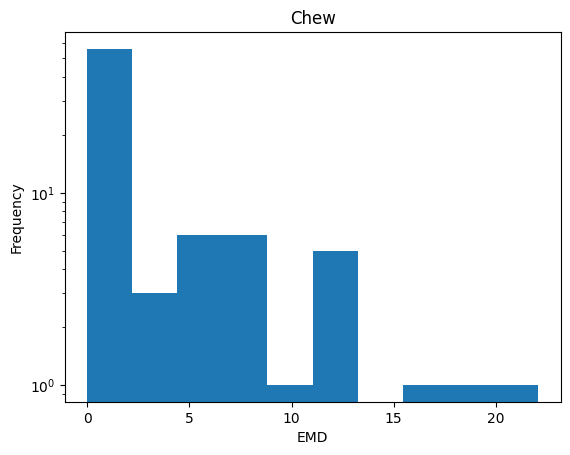

In [16]:
plt.hist(np.asarray(chew))
plt.xlabel('EMD')
plt.ylabel('Frequency')
plt.title('Chew')
plt.yscale("log")

### Same Animal, Different Session

In [17]:
emds2 = list()
row = df.loc[(df['animal_id'] == 'M235Slc17a7_Gtacr2') & (df['session_id'] == '20170424') ]
options = [item.stem for item in row['session_vids'].item()]
session_dir = training_data_path.joinpath(row['animal_id'].item()).joinpath(row['session_id'].item())
deg_labels = np.load(session_dir.joinpath(row['session_id'].item()).with_name('deg_labels.npy'))
for op in tqdm(options):
    trial_index = int(op.split('_v')[-1]) - 1
    jab_ethogram_array, behaviors = container._get_ethogram(trial_index, list(session_dir.glob("*.mat"))[0])
    deg_ethogram_array = deg_labels[trial_index]
    emd = list()
    for jab, deg in zip(jab_ethogram_array, deg_ethogram_array):
        try:
            emd.append(emd_1d(jab, deg))
        except:
            emd.append(0)
    emds2.append(emd)

100%|███████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.41it/s]


In [18]:
lift = list()
handopen = list()
grab = list()
sup = list()
atmouth = list()
chew = list()
for e in emds2: 
    lift.append(e[0])
    handopen.append(e[1])
    grab.append(e[2])
    sup.append(e[3])
    atmouth.append(e[4])
    chew.append(e[5])

In [19]:
max_ix = [ix.index(max(ix)) -1 for ix in [lift, handopen, grab, sup, atmouth, chew]]
max_val = [(max(ix)) for ix in [lift, handopen, grab, sup, atmouth, chew]]

In [20]:
print(max_ix)
print(max_val)

[71, -1, 54, 42, 55, 16]
[66.04444122314453, 62.82143020629883, 40.80769348144531, 109.017578125, 19.700565338134766, 26.739999771118164]


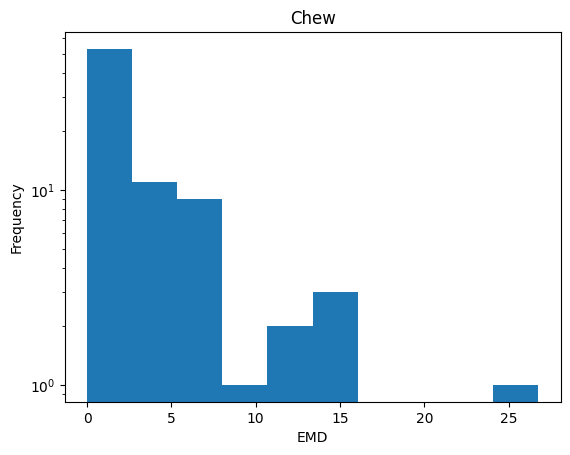

In [21]:
plt.hist(np.asarray(chew))
plt.xlabel('EMD')
plt.ylabel('Frequency')
plt.title('Chew')
plt.yscale("log")

### Calculating Euclidean Distance 

In [ ]:
np.linalg norm(a-b)

### Same animal, different session

In [13]:
eucs = list()
row = df.loc[(df['animal_id'] == 'M235Slc17a7_Gtacr2') & (df['session_id'] == '20170424') ]
options = [item.stem for item in row['session_vids'].item()]
session_dir = training_data_path.joinpath(row['animal_id'].item()).joinpath(row['session_id'].item())
deg_labels = np.load(session_dir.joinpath(row['session_id'].item()).with_name('deg_labels.npy'))
for op in tqdm(options):
    trial_index = int(op.split('_v')[-1]) - 1
    jab_ethogram_array, behaviors = container._get_ethogram(trial_index, list(session_dir.glob("*.mat"))[0])
    deg_ethogram_array = deg_labels[trial_index]
    euc = list()
    for jab, deg in zip(jab_ethogram_array, deg_ethogram_array):
        euc.append(np.linalg.norm(jab-deg))
    eucs.append(euc)

100%|███████████████████████████████████████████████████████████████████████████████| 80/80 [00:04<00:00, 16.06it/s]


In [14]:
lift = list()
handopen = list()
grab = list()
sup = list()
atmouth = list()
chew = list()
for e in eucs: 
    lift.append(e[0])
    handopen.append(e[1])
    grab.append(e[2])
    sup.append(e[3])
    atmouth.append(e[4])
    chew.append(e[5])

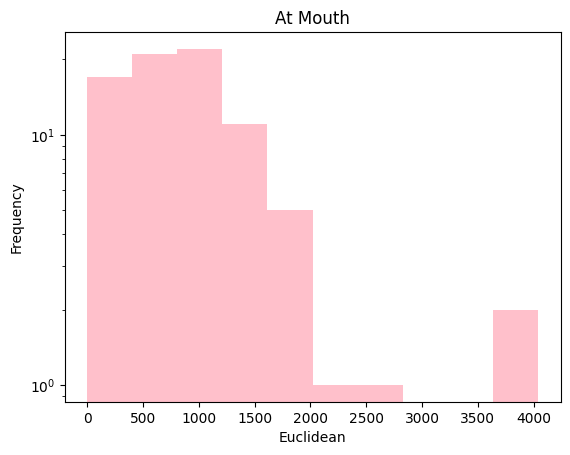

In [20]:
plt.hist(np.asarray(atmouth), color="pink")
plt.xlabel('Euclidean')
plt.ylabel('Frequency')
plt.title('At Mouth')
plt.yscale("log")

In [21]:
max_ix = [ix.index(max(ix)) -1 for ix in [lift, handopen, grab, sup, atmouth, chew]]
max_val = [(max(ix)) for ix in [lift, handopen, grab, sup, atmouth, chew]]

In [22]:
print(max_ix)
print(max_val)

[71, 46, 28, 27, 1, 24]
[1249.2525765432706, 1612.7640869017391, 1821.0724862014692, 5991.144882240789, 4039.959777027489, 3295.326539206699]


### Different animal, euclidean

In [23]:
eucs2 = list()
row = df.loc[(df['animal_id'] == 'M236Slc17a7_Gtacr2') & (df['session_id'] == '20170501') ]
options = [item.stem for item in row['session_vids'].item()]
session_dir = training_data_path.joinpath(row['animal_id'].item()).joinpath(row['session_id'].item())
deg_labels = np.load(session_dir.joinpath(row['session_id'].item()).with_name('deg_labels.npy'))
for op in tqdm(options):
    trial_index = int(op.split('_v')[-1]) - 1
    jab_ethogram_array, behaviors = container._get_ethogram(trial_index, list(session_dir.glob("*.mat"))[0])
    deg_ethogram_array = deg_labels[trial_index]
    euc = list()
    for jab, deg in zip(jab_ethogram_array, deg_ethogram_array):
        euc.append(np.linalg.norm(jab-deg))
    eucs2.append(euc)

100%|███████████████████████████████████████████████████████████████████████████████| 80/80 [00:05<00:00, 15.58it/s]


In [24]:
lift = list()
handopen = list()
grab = list()
sup = list()
atmouth = list()
chew = list()
for e in eucs2: 
    lift.append(e[0])
    handopen.append(e[1])
    grab.append(e[2])
    sup.append(e[3])
    atmouth.append(e[4])
    chew.append(e[5])

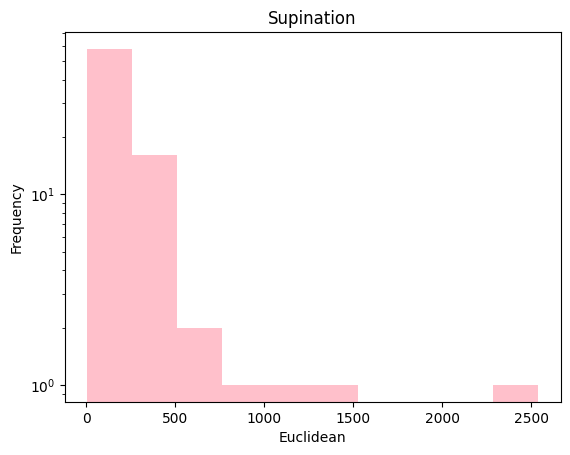

In [29]:
plt.hist(np.asarray(atmouth), color="pink")
plt.xlabel('Euclidean')
plt.ylabel('Frequency')
plt.title('Supination')
plt.yscale("log")